In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

def min_rayleigh(kzeta, k2, pot, eps, maxcyc):
    """
    Function:   minimize the Rayleigh quotient of the Hamiltonian
                    < H > = < zeta | - nabla ^ 2 + pot | zeta > / < zeta | zeta >.
                FFTs are used, so kzeta = fft(zeta), and
                    < H > = [< kzeta | k2 | kzeta > + < zeta | pot | zeta >] / < zeta | zeta >.
                The steepest descent algorithm is used for the minimization procedure.
                (For quantum mechanics people: the Rayleigh quotient is the expectation value,
                and the minimum for the Hamiltonian defines the ground state.)
    Input:      kzeta:      a vector on a 3-dimensional grid (reciprocal space), containing an initial
                            guess for the ground state.
                k2:         a vector containing the kinetic energy operator in reciprocal space.
                pot:        the potential on a 3-dimensional grid in real space.
                eps:        convergence parameter for the Rayleigh quotient.
                maxcyc:     the maximum number of allowed steepest descent iterations.
    Output:     rayleigh:   a vector of length numcyc, containing the Rayleigh quotients of all
                            steepest descent iterations.
                kzeta:      a vector on a 3-dimensional grid (reciprocal space), containing the best
                            guess for the ground state; normalized to one.
                numcyc:     the number of cycles used to converge the Rayleigh quotient.
    Errors:     just a couple of warnings, if convergence is not reached.
    """

    rayleigh = []

    # normalize the input vector
    gamma = 1.0 / np.sqrt(inner3d(kzeta, kzeta))
    kzeta = kzeta * gamma

    # initialize 2x2 steepest descent matrices
    A = np.zeros((2, 2))
    B = np.zeros((2, 2))

    # initial Rayleigh quotient and residual vector
    kzetaop = operation(kzeta, k2, pot)
    rayleigh.append(inner3d(kzeta, kzetaop))
    kresidue = (kzetaop - rayleigh[0] * kzeta) / k2
    kresidue[~np.isfinite(kresidue)] = 0 # set non-finite values to zero

    # steepest descent iterate
    for i in range(1, maxcyc):
        kresop = operation(kresidue, k2, pot)

        # construct 2x2 matrices
        A[0, 0] = inner3d(kzeta, kzetaop)
        A[0, 1] = inner3d(kzeta, kresop)
        A[1, 0] = inner3d(kresidue, kzetaop)
        A[1, 1] = inner3d(kresidue, kresop)

        B[0, 0] = inner3d(kzeta, kzeta)
        B[0, 1] = inner3d(kzeta, kresidue)
        B[1, 0] = B[0, 1]
        B[1, 1] = inner3d(kresidue, kresidue)

        # solve the 2x2 generalized eigenvalue problem
        eigvals, eigvecs = eig(A, B)
        idx = eigvals.argsort()

        s_eigvals = eigvals[idx]
        s_eigvecs = eigvecs[:, idx]

        rayleigh.append(np.real(s_eigvals[0]))

        # update vectors
        kzeta = s_eigvecs[0, 0] * kzeta + s_eigvecs[1, 0] * kresidue
        kzetaop = s_eigvecs[0, 0] * kzetaop + s_eigvecs[1, 0] * kresop

        # normalize
        gamma = 1.0 / np.sqrt(inner3d(kzeta, kzeta))
        kzeta = kzeta * gamma
        kzetaop = kzetaop * gamma

        # new residual vector
        kresidue = (kzetaop - rayleigh[i] * kzeta) / k2
        kresidue[~np.isfinite(kresidue)] = 0 # set non-finite values to zero

        # check convergence
        if abs(rayleigh[i] - rayleigh[i - 1]) < eps:
            break

    numcyc = i

    # some mimimal checks
    if numcyc >= maxcyc:
        print('*** warning ***, function min_rayleigh, number of cycles exceeded maximum')

    if abs(rayleigh[numcyc] - rayleigh[numcyc - 1]) > eps:
        print('*** warning ***, function min_rayleigh, result has not converged')

    return rayleigh, kzeta, numcyc

def operation(invec, k2, pot):
    """
    Function:   returns the Hamiltonian operator - nabla ^ 2 psi + pot * psi, but everything in
                reciprocal space, so
                    outvec = k ^ 2 invec + FFT(pot * IFFT(invec))
    Input:      invec:      a vector on a n-dimensional grid in reciprocal space.
                k2:         the sizes^2 of the grid vectors in reciprocal space.
                pot:        the potential on a n-dimensional grid in real space.
    Output:     outvec:     a vector on a n-dimensional grid in real space, containing the result of
                            the operations.
    Errors:     none, you're on your own.
    """
    tmpvec = np.fft.ifftn(invec)
    outvec = k2 * invec + np.fft.fftn(pot * tmpvec)

    return outvec

def inner3d(v1, v2):
    """
    Function:   calculates the inner product between two 3-dimensional vectors.
    Input:      v1:         first 3-dimensional vector.
                v2:         second 3-dimensional vector.
    Output:     sum3d:      result of the inner product in 3 dimensions.
    """
    new3d = np.vdot(v1.ravel(), v2.ravel())

    return np.real(new3d)

def poisson(dens, k2):
    """
    Function:   solves the n-dimensional Poisson equation on a grid:
                    nabla pot = 2 * dens
    Input:      dens:   a density on a n-dimensional grid in real space.
                k2:     the sizes^2 of the grid vectors in reciprocal space in an order consistent
                        with the FFTs.
    Output:     pot:    the potential on the n-dimensional grid in real space. The average potential
                        (averaged over the grid) is set to zero. The output units are Rydberg energy.
    Errors:     none, you're on your own.
    """
    densg = np.fft.fftn(dens) # reciprocal space charge density
    potg = 8 * np.pi * densg / k2 # reciprocal space potential
    potg[~np.isfinite(potg)] = 0 # set non-finite values to zero
    pot = np.fft.ifftn(potg) # real space potential

    return pot

def hfsa(dens, step):
    """
    Function:   calculates the Hartree-Fock-Slater approximation to the local density approximation,
                which means exchange only, of the XC energy and potential in Rydberg units.
    Input:      dens:       a density on a 3-dimensional grid in real space.
                step:       the step size of this grid.
    Output:     ex:         the exchange energy.
                vx:         the exchange potential.
    Errors:     none, you're on your own.
    ! NOTE: alpha is a parameter that controles the strength of the exchange interaction; alpha = 1 is the Kohn-Sham value. !
    """
    alpha = 0.8
    vx = (3 * dens / np.pi) ** (1 / 3)
    vx = -2 * vx * alpha
    ex = -(6 / 4) * (3 / np.pi) ** (1 / 3) * np.sum(np.sum(np.sum(dens ** (4 / 3)))) * step ** 3 * alpha

    return np.real(ex), np.real(vx)

### Switch of ZeroDivisionError
# Errors/Warnings usually raised when dividing an array element by zero will
# be switched off and dealt with by explicitly setting these elements
np.seterr(invalid='ignore', divide='ignore')

# set up of the grid in real space
N_grid = 128
r_stop = 10.0
h = r_stop / (N_grid - 1)
ints = np.linspace(-N_grid/2, N_grid/2 - 1, N_grid)
n1, n2, n3 = np.meshgrid(ints, ints, ints)

# kinetic energy operator in reciprocal space
deltak2 = (2 * np.pi / r_stop) ** 2
k2 = (n1 ** 2 + n2 ** 2 + n3 ** 2) * deltak2

# grid shift for zero vector at the beginning required for FFT routines
k2 = np.roll(k2, int(N_grid / 2), axis=0)
k2 = np.roll(k2, int(N_grid / 2), axis=1)
k2 = np.roll(k2, int(N_grid / 2), axis=2)

# set up a (normalized) gaussian nuclear charge density in real space
sigma = 0.1
nuc = np.exp(-(n1 ** 2 + n2 ** 2 + n3 ** 2) * h ** 2 / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma) ** 3

# Coulomb self-energy of this Gaussian
enself = 1 / (sigma * np.sqrt(np.pi))

distances = np.concatenate([np.linspace(2*0.6, 2*1.2, 10), np.linspace(1.7, 1.8, 5)])
energies = np.zeros(len(distances))

for index, dist in enumerate(distances):
    #####################################################
    ### CODE BLOCK: set up the initial charge density ###
    # internuclear distance
    # dist = 2.0
    shift = int(round(dist / (2 * h)))
    real_dist = 2 * shift * h

    # two nuclear potentials shifted along the x-axis by plus-minus dist/2
    nuc1 = np.roll(nuc, shift, axis=0)
    nuc2 = np.roll(nuc, -shift, axis=0)

    # trial wave function and density based upon hydrogen 1s functions
    zeta = np.exp(- np.sqrt(n1 ** 2 + n2 ** 2 + n3 ** 2) * h)
    zeta1 = np.roll(zeta, shift, axis=0)
    zeta2 = np.roll(zeta, -shift, axis=0)
    zeta = zeta1 + zeta2

    gamma = inner3d(zeta, zeta) * h ** 3
    zeta = zeta / np.sqrt(gamma) # wavefunction normalization
    dens = 2 * zeta ** 2 # charge density
    ### CODE BLOCK: set up the initial charge density ###
    #####################################################

    #####################################################
    ### CODE BLOCK: calculate the total system energy ###
    totdens = dens - nuc1 - nuc2 # total (electron + nuclear) charge density
    coulombpot = poisson(totdens, k2) # electronic Coulomb potential
    enx, xpot = hfsa(dens, h) # Hartree-Fock-Slater exchange energy and potential
    pot = coulombpot + xpot # total potential

    kzeta = np.fft.fftn(zeta) # wavefunction in reciprocal space
    kinzeta = 2 * kzeta * k2 # kinetic energy (calculated in reciprocal space)
    enkin = np.real(inner3d(kzeta, kinzeta)) * (h / N_grid) ** 3 # real-space projection of energy

    enhartree = 0.5 * inner3d(coulombpot, totdens) * h ** 3 - 2 * enself # Coulomb energy terms
    entot = enkin + enhartree + enx # total energy
    ### CODE BLOCK: calculate the total system energy ###
    #####################################################

    ###################################################
    ### CODE BLOCK: Rayleigh criterion minimization ###
    maxcyc = 100 # maximum number of cycles
    eps_rayleigh = 1E-5 # eigenvalue convergence criterion

    # minimization of Rayleigh quotient
    rayleigh, kzeta, numcyc = min_rayleigh(kzeta, k2, pot, eps_rayleigh, maxcyc)
    eigval = np.real(rayleigh[-1])
    ### CODE BLOCK: Rayleigh criterion minimization ###
    ###################################################

    #####################################################################
    ### CODE BLOCK: determine normalized eigen function in real space ###
    zeta = np.fft.ifftn(kzeta)
    gamma = inner3d(zeta, zeta) * h ** 3
    zeta = zeta / np.sqrt(gamma)
    dens = 2 * np.multiply(np.conj(zeta), zeta)
    totdens = dens - nuc1 - nuc2
    ### CODE BLOCK: determine normalized eigen function in real space ###
    #####################################################################

    #####################################################
    ### CODE BLOCK: calculate the total system energy ###
    totdens = dens - nuc1 - nuc2 # total (electron + nuclear) charge density
    coulombpot = poisson(totdens, k2) # electronic Coulomb potential
    enx, xpot = hfsa(dens, h) # Hartree-Fock-Slater exchange energy and potential
    pot = coulombpot + xpot # total potential

    kzeta = np.fft.fftn(zeta) # wavefunction in reciprocal space
    kinzeta = 2 * kzeta * k2 # kinetic energy (calculated in reciprocal space)
    enkin = np.real(inner3d(kzeta, kinzeta)) * (h / N_grid) ** 3 # real-space projection of energy

    enhartree = 0.5 * inner3d(coulombpot, totdens) * h ** 3 - 2 * enself # Coulomb energy terms
    entot = enkin + enhartree + enx # total energy
    ### CODE BLOCK: calculate the total system energy ###
    #####################################################
    # print(f'{dist} {k2}')
    energies[index] = entot
    print(f'\r{index}', end='')

KeyboardInterrupt: 

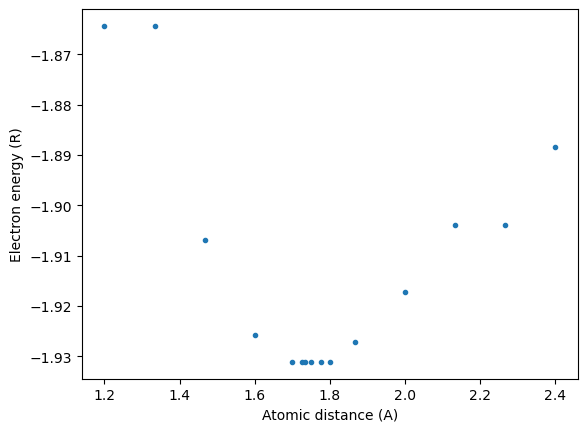

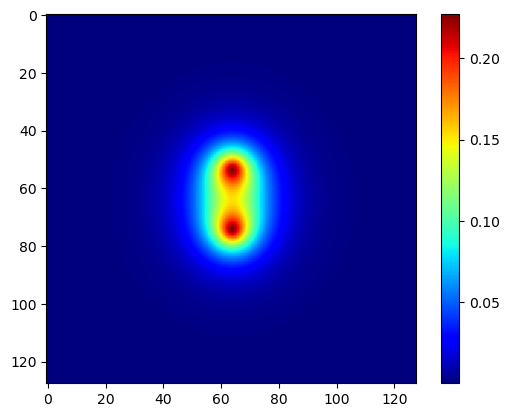

In [26]:
plt.figure()
plt.plot(distances, energies, '.')  # 0.74 A
plt.ylabel('Electron energy (R)')
plt.xlabel('Atomic distance (A)')
plt.show()

plt.figure()
plt.imshow(np.abs(dens[:, int(dens.shape[-2]/2), :]), cmap='jet')
plt.colorbar()
plt.show()